In [ ]:
# !rm -rf WGAN
# !rm -rf WGAN.zip
!unzip WGAN.zip
!pip install pot

Archive:  WGAN.zip
   creating: WGAN/
  inflating: WGAN/Losses.py          
  inflating: WGAN/NNs.py             
  inflating: WGAN/utils.py           
   creating: WGAN/__pycache__/
  inflating: WGAN/__pycache__/Losses.cpython-37.pyc  
  inflating: WGAN/__pycache__/NNs.cpython-37.pyc  
  inflating: WGAN/__pycache__/utils.cpython-37.pyc  
     |████████████████████████████████| 440kB 9.3MB/s 


In [ ]:
from WGAN.NNs import DiscriminatorMLP, DiscriminatorConvNet
from WGAN.utils import divide_by_classes, Trainer
from WGAN.Losses import GPLoss, WCLoss, WeightClipper, CEpsilonLoss, CLoss, LPLoss

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.utils as vutils

from torch.autograd import Variable
import torch.autograd as autograd

import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np
from tqdm.notebook import tqdm

from itertools import product

import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize((32, 32)),
    ]
)

In [ ]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

import MNIST

--2021-03-23 19:37:22--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-23 19:37:22--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [       <=>          ]  33.20M  27.6MB/s    in 1.2s    

2021-03-23 19:37:23 (27.6 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
datasets_names = ['CIFAR10', 'MNIST']
datasets_check = {'CIFAR10': (datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=True),
                        datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=False)),
            'MNIST': (datasets.MNIST(root = './', train=True, download=True, transform=transform),
                      datasets.MNIST(root = './', train=False, download=True, transform=transform))}

batch_sizes = list(product([64, 512], [64, 512]))

models = []

dataset_name = 'MNIST'
dataset_train, dataset_test = datasets_check[dataset_name]
N, M = batch_sizes[0]

train_part1, train_part2 = divide_by_classes(dataset_train, N, cifar=False)
test_part1, test_part2 = divide_by_classes(dataset_test, M, cifar=False)

check_image = next(iter(train_part1))

epochs = 20
num_of_channels = check_image.size(1)
image_size = check_image.size(2)


Extracting cifar/cifar-10-python.tar.gz to cifar/
Files already downloaded and verified


In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = WCLoss()

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    weight_clipper=WeightClipper(0.03)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -0.9821522



Val epoch 1 , Mean error : -0.74156863



Val epoch 2 , Mean error : -0.58127448



Val epoch 3 , Mean error : -0.47527923



Val epoch 4 , Mean error : -0.39676022



Val epoch 5 , Mean error : -0.33835899



Val epoch 6 , Mean error : -0.29364942



Val epoch 7 , Mean error : -0.25716855



Val epoch 8 , Mean error : -0.22549097



Val epoch 9 , Mean error : -0.19891243



Val epoch 10 , Mean error : -0.17313422



Val epoch 11 , Mean error : -0.15322291



Val epoch 12 , Mean error : -0.13413265



Val epoch 13 , Mean error : -0.11787421



Val epoch 14 , Mean error : -0.10304664



Val epoch 15 , Mean error : -0.090578483



Val epoch 16 , Mean error : -0.079301663



Val epoch 17 , Mean error : -0.069187105



Val epoch 18 , Mean error : -0.059166015



Val epoch 19 , Mean error : -0.049987879


Average error for conv is: 0.184+-0.011


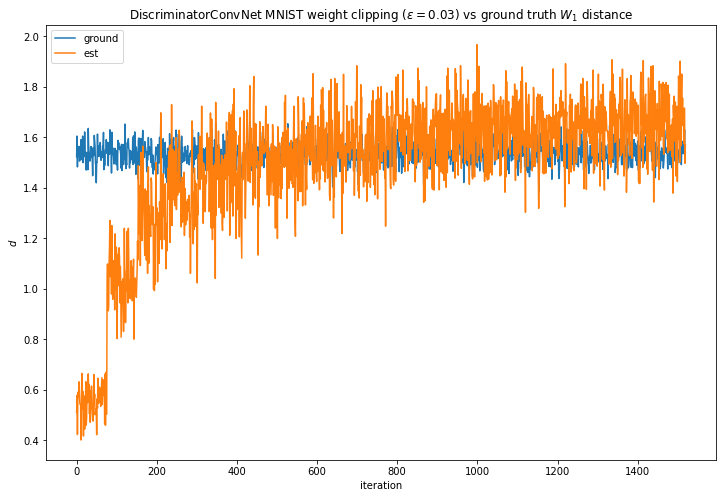

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} weight clipping $(\epsilon=0.03)$ vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = GPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.008

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -1.6604296
Val epoch 0 , Stability : -1120.7789



Val epoch 1 , Mean error : -1.6181534
Val epoch 1 , Stability : -0.58071024



Val epoch 2 , Mean error : -2.0901412
Val epoch 2 , Stability : 1.3004887



Val epoch 3 , Mean error : -2.0669177
Val epoch 3 , Stability : 0.33368774



Val epoch 4 , Mean error : -1.9700117
Val epoch 4 , Stability : -0.074763193



Val epoch 5 , Mean error : -1.9727618
Val epoch 5 , Stability : 0.34392267



Val epoch 6 , Mean error : -1.9539026
Val epoch 6 , Stability : 0.21634738



Val epoch 7 , Mean error : -1.945345
Val epoch 7 , Stability : 0.2776076



Val epoch 8 , Mean error : -1.9266081
Val epoch 8 , Stability : 0.16624157



Val epoch 9 , Mean error : -1.9355273
Val epoch 9 , Stability : 0.40235781



Val epoch 10 , Mean error : -2.0275264
Val epoch 10 , Stability : 1.3388112



Val epoch 11 , Mean error : -2.0446302
Val epoch 11 , Stability : 0.62815965



Val epoch 12 , Mean error : -2.1013489
Val epoch 12 , Stability : 1.181242



Val epoch 13 , Mean error : -2.1066848
Val epoch 13 , Stability : 0.58254936



Val epoch 14 , Mean error : -2.2061964
Val epoch 14 , Stability : 2.0046497



Val epoch 15 , Mean error : -2.2665375
Val epoch 15 , Stability : 1.5793741



Val epoch 16 , Mean error : -2.3741641
Val epoch 16 , Stability : 2.5035873



Val epoch 17 , Mean error : -2.4037715
Val epoch 17 , Stability : 1.3232269



Val epoch 18 , Mean error : -2.4649721
Val epoch 18 , Stability : 1.9893049



Val epoch 19 , Mean error : -2.6118575
Val epoch 19 , Stability : 3.8204952


Average error for conv is: 2.612+-0.049


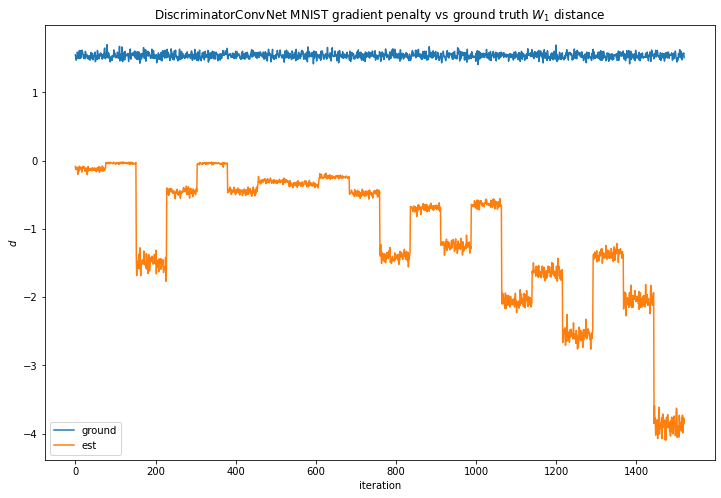

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} gradient penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 2.612+-0.049


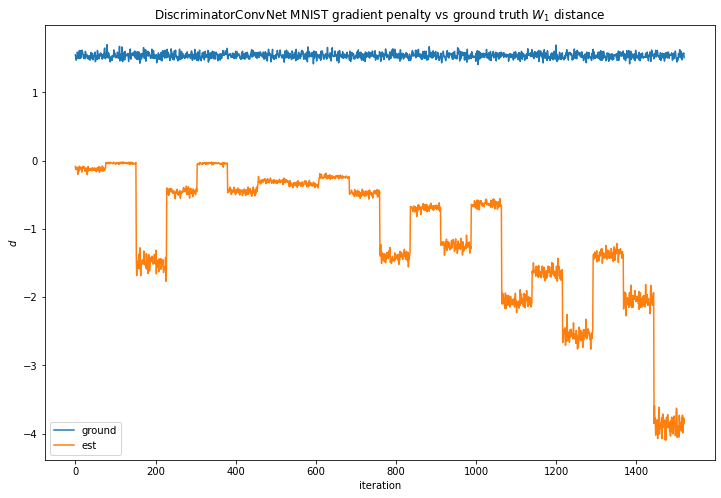

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} gradient penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorConvNet_MNIST_GPLoss.pdf /content/drive/MyDrive/Sk/ML/Project/ConvNet/MNIST

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = LPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.0001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -67.730056



Val epoch 1 , Mean error : -67.51496



Val epoch 2 , Mean error : -71.738361



Val epoch 3 , Mean error : -86.492071



Val epoch 4 , Mean error : -84.732972



Val epoch 5 , Mean error : -84.319411



Val epoch 6 , Mean error : -90.319478



Val epoch 7 , Mean error : -88.349011



Val epoch 8 , Mean error : -81.283561



Val epoch 9 , Mean error : -74.806311



Val epoch 10 , Mean error : -70.166685



Val epoch 11 , Mean error : -66.179762



Val epoch 12 , Mean error : -62.83018



Val epoch 13 , Mean error : -61.941975



Val epoch 14 , Mean error : -59.209501



Val epoch 15 , Mean error : -59.551069



Val epoch 16 , Mean error : -59.598603



Val epoch 17 , Mean error : -59.20938



Val epoch 18 , Mean error : -59.596996



Val epoch 19 , Mean error : -61.649869


Average error for conv is: 61.65+-1.659


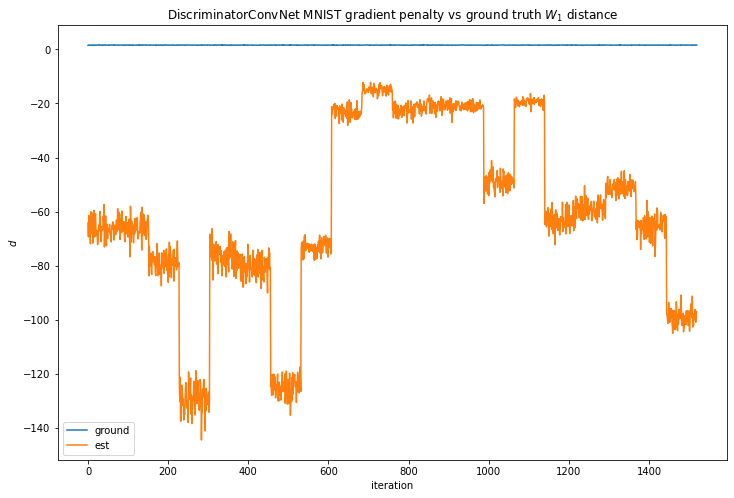

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} Lipschitz penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 61.65+-1.659


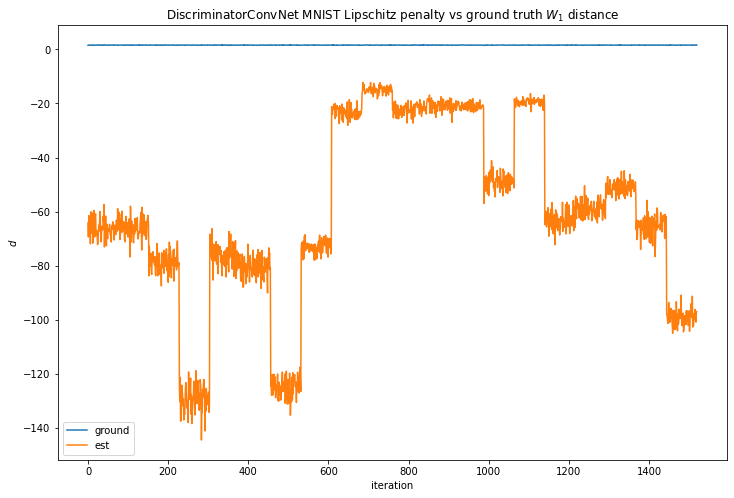

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} Lipschitz penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorConvNet_MNIST_LPLoss.pdf /content/drive/MyDrive/MLProject/ConvNet/MNIST

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CLoss()
criterion.optimizer_params['lr'] = 0.001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -0.1532156



Val epoch 1 , Mean error : -0.11333597



Val epoch 2 , Mean error : -0.09981789



Val epoch 3 , Mean error : -0.08985342



Val epoch 4 , Mean error : -0.084452225



Val epoch 5 , Mean error : -0.080722548



Val epoch 6 , Mean error : -0.077726813



Val epoch 7 , Mean error : -0.075029555



Val epoch 8 , Mean error : -0.073568996



Val epoch 9 , Mean error : -0.072063142



Val epoch 10 , Mean error : -0.071022297



Val epoch 11 , Mean error : -0.070138782



Val epoch 12 , Mean error : -0.069052236



Val epoch 13 , Mean error : -0.068415519



Val epoch 14 , Mean error : -0.067783804



Val epoch 15 , Mean error : -0.06723951



Val epoch 16 , Mean error : -0.066642024



Val epoch 17 , Mean error : -0.066020284



Val epoch 18 , Mean error : -0.065504743



Val epoch 19 , Mean error : -0.065064376


Average error for conv is: 0.065+-0.001


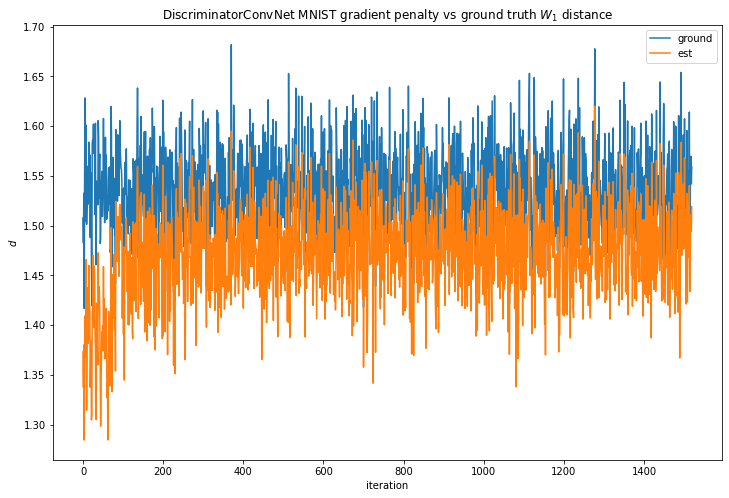

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} $c$-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 0.065+-0.001


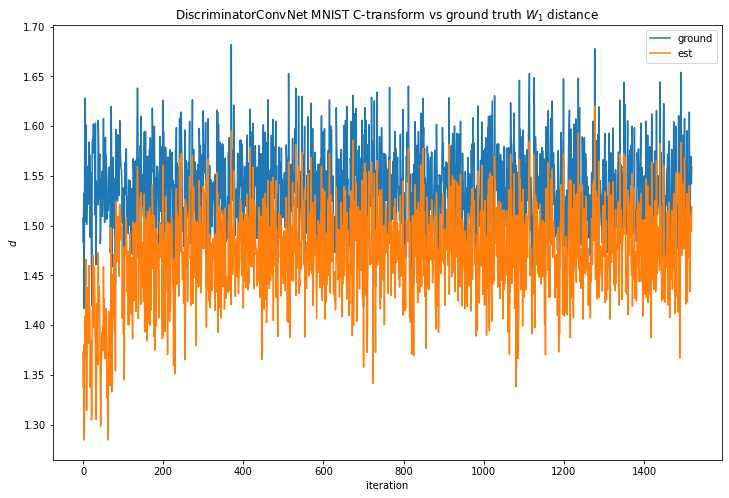

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} C-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorConvNet_MNIST_CLoss.pdf /content/drive/MyDrive/MLProject/ConvNet/MNIST

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CEpsilonLoss(12)
criterion.optimizer_params['lr'] = 0.0001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : 0.17086479



Val epoch 1 , Mean error : 0.16678065



Val epoch 2 , Mean error : 0.17334312



Val epoch 3 , Mean error : 0.17492215



Val epoch 4 , Mean error : 0.17670734



Val epoch 5 , Mean error : 0.17920597



Val epoch 6 , Mean error : 0.17930137



Val epoch 7 , Mean error : 0.18052546



Val epoch 8 , Mean error : 0.18153801



Val epoch 9 , Mean error : 0.18223861



Val epoch 10 , Mean error : 0.18240315



Val epoch 11 , Mean error : 0.18306393



Val epoch 12 , Mean error : 0.1835914



Val epoch 13 , Mean error : 0.1839937



Val epoch 14 , Mean error : 0.18423926



Val epoch 15 , Mean error : 0.18454801



Val epoch 16 , Mean error : 0.18489678



Val epoch 17 , Mean error : 0.18509296



Val epoch 18 , Mean error : 0.18537193



Val epoch 19 , Mean error : 0.18559613


Average error for conv is: 0.186+-0.001


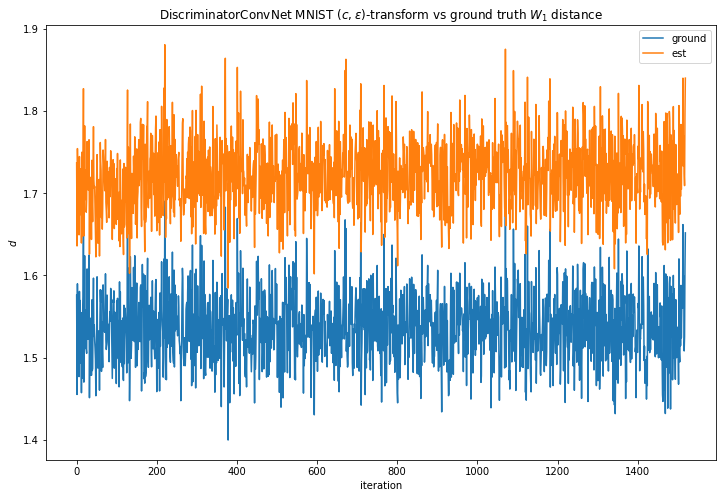

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} ($c, \epsilon$)-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 0.186+-0.001


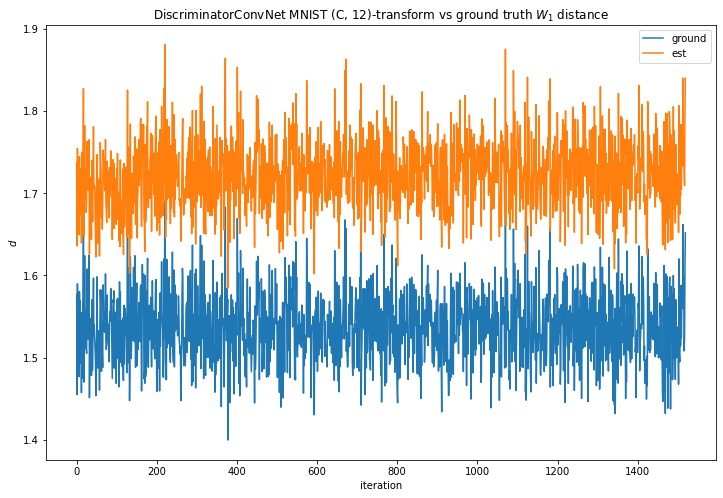

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} (C, 12)-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorConvNet_MNIST_CEpsilonLoss.pdf /content/drive/MyDrive/MLProject/MLP/MNIST